Ideas:
* https://arxiv.org/abs/1803.05400
* https://arxiv.org/pdf/1712.03400.pdf
* https://github.com/prajwaldp/gan-image-colorizer/blob/master/Report/Report.pdf

In [22]:
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import (
    Activation, AveragePooling2D, BatchNormalization, RepeatVector, Conv2D, Conv2DTranspose,
    Dense, Dropout, Flatten, concatenate, Input, LeakyReLU, ReLU, Reshape, Activation, UpSampling2D)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.utils import plot_model
from time import time
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize

EPOCHS = 100
BATCH_SIZE = 32
LAMBDA = 10

# 100 MAX
TEST_SIZE = 100
# 4000 MAX
TRAIN_SIZE = 1000

SHUFFLE_BUFFER_SIZE = 100

IMAGE_SIZE = 224
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [23]:
# Load full train and test sets
full_train = np.load("/kaggle/input/landascapes-splitted/train_set.npy")
full_test = np.load("/kaggle/input/landascapes-splitted/test_set.npy")

In [24]:
print(full_train.shape)
print(full_test.shape)

(4000, 224, 224, 3)
(100, 224, 224, 3)


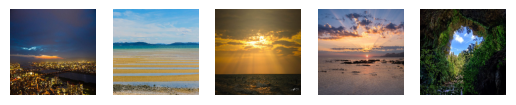

In [25]:
for i, img in enumerate(full_train[:5]):
    plt.subplot(1, 5, i+1)
    plt.imshow(img/255)
    plt.axis('off')
plt.show()

In [26]:
# Transform both datasets into grayscale (X) and ab (y) channels and normalize

c_train = full_train[:TRAIN_SIZE]
c_test = full_test[:TEST_SIZE]

X_train = []
y_train = []
for img in c_train:
    lab_array = rgb2lab(img/255)
    l = lab_array[:, :, 0]
    ab = (lab_array[:, :, 1:])/128
    
    X_train.append(l.reshape(IMG_WIDTH, IMG_HEIGHT, 1))
    y_train.append(ab)
    
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

X_test = []
y_test = []
for img in c_test:
    lab_array = rgb2lab(img/ 255)
    l = lab_array[:, :, 0]
    ab = (lab_array[:, :, 1:])/128
    
    X_test.append(l.reshape(IMG_WIDTH, IMG_HEIGHT, 1))
    y_test.append(ab)
    
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [27]:
print(X_train.shape)
print(y_train.shape)

(1000, 224, 224, 1)
(1000, 224, 224, 2)


In [28]:
# Transform training data into a tf.data.Dataset object and then group by batch size
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

# GENERATOR

In [29]:
inception = InceptionResNetV2(include_top=True)

In [30]:
def inception_embedding(bw_imgs):
    grayscaled_rgb_resized = []
    for i in bw_imgs:
        i = resize(i, (299, 299))
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    embed = inception.predict(grayscaled_rgb_resized)
    return embed

In [31]:
def downsample(filters, kernel_size, apply_batchnorm=True):
    initializer = tf.random_uniform_initializer(0, 0.02)
    model = Sequential()
    model.add(Conv2D(filters, kernel_size, strides=2, padding='same',
                     kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        model.add(BatchNormalization())

    model.add(LeakyReLU())
    return model


def upsample(filters, kernel_size, apply_dropout=False):
    initializer = tf.random_uniform_initializer(0, 0.02)
    model = Sequential()
    model.add(Conv2DTranspose(filters, kernel_size, strides=2, padding='same',
                              kernel_initializer=initializer, use_bias=False))
    model.add(BatchNormalization())

    if apply_dropout:
        model.add(Dropout(0.5))

    model.add(ReLU())
    return model

def get_generator():
    initializer = tf.random_uniform_initializer(0, 0.02)
    
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))    
    embed_input = Input(shape=(1000,))

    downstack = [
        downsample(32, 4, apply_batchnorm=False),
        downsample(64, 4),
        downsample(128, 4),
        downsample(256, 4),
        downsample(256, 4)
    ]
    
    upstack = [
        upsample(256, 4, apply_dropout=True),
        upsample(128, 4),
        upsample(64, 4),
        upsample(32, 4),
    ]

    output_layer = Conv2DTranspose(2, 3, strides=2, padding='same',
                                   kernel_initializer=initializer,
                                   activation='tanh')
    
    x = inputs

    # Downsampling layers
    skips = []
    for dm in downstack:
        x = dm(x)
        skips.append(x)
        
    fusion_output = RepeatVector(7 * 7)(embed_input)
    fusion_output = Reshape(([7, 7, 1000]))(fusion_output)
    fusion_output = concatenate([x, fusion_output], axis=3)
    x = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)


    skips = reversed(skips[:-1])

    # Upsampling layers
    for um, skip in zip(upstack, skips):
        x = um(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    
    x = output_layer(x)

    return Model(inputs=[inputs,embed_input], outputs=x)

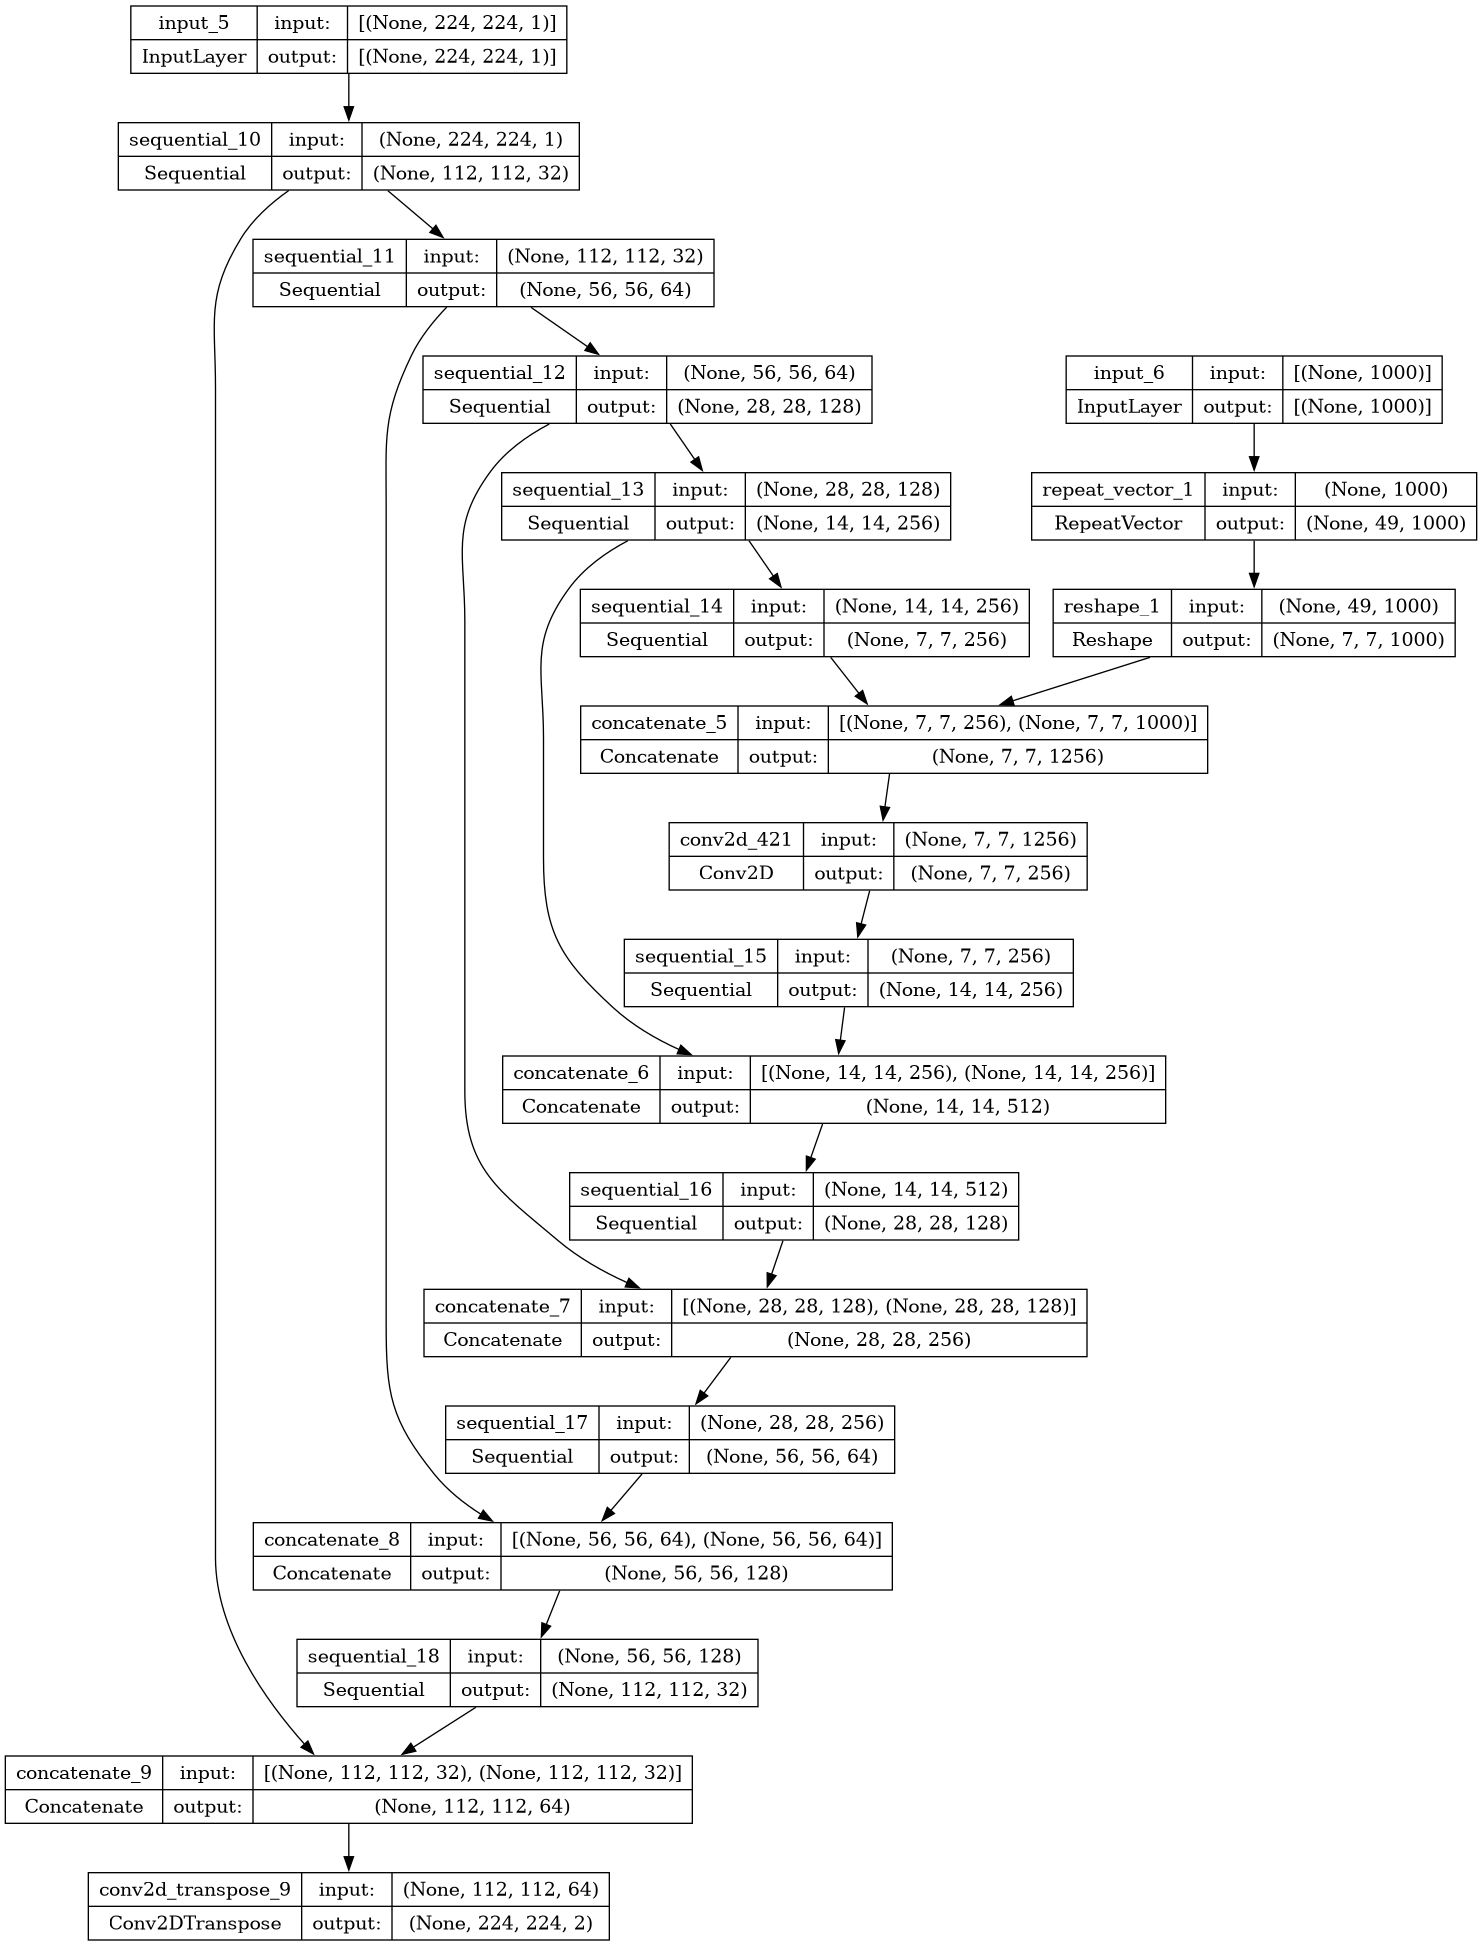

In [32]:
generator = get_generator()
plot_model(generator, show_shapes = True)

# DISCRIMINATOR

In [33]:
def get_discriminator():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Dropout(.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(LeakyReLU(.2))
    model.add(BatchNormalization())
    model.add(Dropout(.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    return model

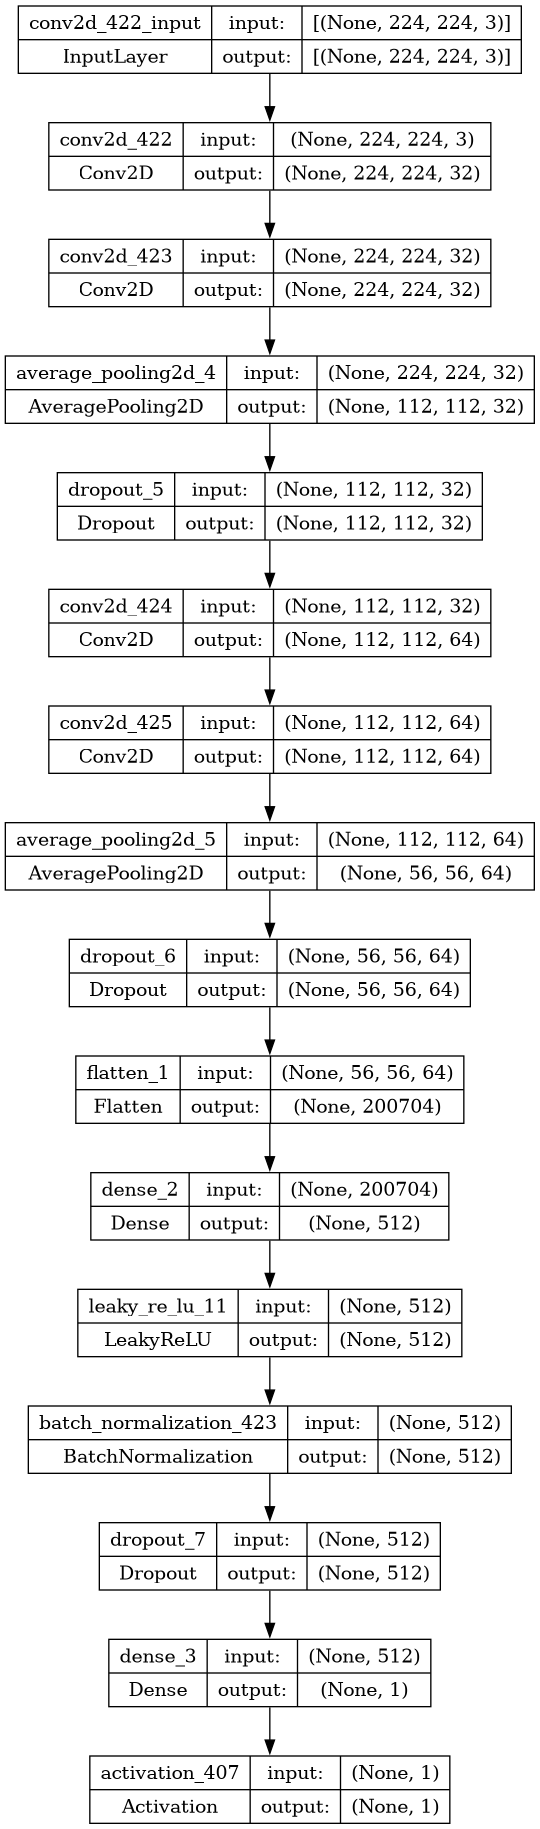

In [34]:
discriminator = get_discriminator()
plot_model(discriminator, show_shapes = True)

# LOSSES

In [35]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [36]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = cross_entropy(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = cross_entropy(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss


def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = cross_entropy(tf.ones_like(disc_generated_output), disc_generated_output)
    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

# TRAINING

In [37]:
@tf.function
def train_step(input_image, embed, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator([input_image,embed], training=True)

        disc_real_output = discriminator(tf.keras.layers.concatenate([input_image, target]), training=True)
        disc_generated_output = discriminator(tf.keras.layers.concatenate([input_image, gen_output]), training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                 discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
    
    return gen_total_loss, disc_loss

In [ ]:
for e in range(EPOCHS):
    start_time = time()
    gen_loss_total = disc_loss_total = 0
    for input_image, target in train_dataset:
        
        resnet_input = gray2rgb(input_image)
        resnet_input = np.moveaxis(resnet_input, -1, -2)
        resnet_input = np.squeeze(resnet_input, axis=-1)
    
        embed = inception_embedding(resnet_input*255)
        
        gen_loss, disc_loss = train_step(input_image, embed, target, e)
        gen_loss_total += gen_loss
        disc_loss_total += disc_loss

    time_taken = time() - start_time

    if (e + 1) % 10 == 0:
        print('Epoch {}: gen loss: {}, disc loss: {}'.format(
            e + 1, gen_loss_total / BATCH_SIZE, disc_loss_total / BATCH_SIZE))

1/1 [==============================] - 4s 4s/step


2024-01-30 11:10:13.954608: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 3s 3s/step


2024-01-30 11:10:52.152221: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 81ms/step


2024-01-30 11:10:54.865947: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 37ms/step


2024-01-30 11:11:25.800415: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 81ms/step


2024-01-30 11:11:28.503297: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 37ms/step


2024-01-30 11:11:59.465014: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 80ms/step


2024-01-30 11:12:02.456002: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 41ms/step


2024-01-30 11:12:33.541589: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 86ms/step


2024-01-30 11:12:36.278718: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 42ms/step


2024-01-30 11:13:07.105444: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 84ms/step


2024-01-30 11:13:09.802020: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 41ms/step


2024-01-30 11:13:40.792797: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 81ms/step


2024-01-30 11:13:43.467861: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 37ms/step


2024-01-30 11:14:14.388284: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 84ms/step


2024-01-30 11:14:17.075548: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 39ms/step


2024-01-30 11:14:48.021058: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 81ms/step


2024-01-30 11:14:50.757378: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 37ms/step


2024-01-30 11:15:21.558018: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 80ms/step


2024-01-30 11:15:24.276900: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 44ms/step


2024-01-30 11:15:55.806477: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 10: gen loss: 1.708945393562317, disc loss: 1.7259485721588135
1/1 [==============================] - 0s 80ms/step


2024-01-30 11:15:58.551232: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 37ms/step


2024-01-30 11:16:29.203151: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 80ms/step


2024-01-30 11:16:31.852401: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 39ms/step


2024-01-30 11:17:02.816091: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 79ms/step


2024-01-30 11:17:05.484777: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 42ms/step


2024-01-30 11:17:36.375106: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 80ms/step


2024-01-30 11:17:39.110743: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 37ms/step


2024-01-30 11:18:10.185940: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 81ms/step


2024-01-30 11:18:12.886201: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 41ms/step


2024-01-30 11:18:43.803180: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 80ms/step


2024-01-30 11:18:46.480315: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 37ms/step


2024-01-30 11:19:17.333071: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 87ms/step


2024-01-30 11:19:20.098862: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 38ms/step


2024-01-30 11:19:51.592982: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 81ms/step


2024-01-30 11:19:54.284036: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 42ms/step


2024-01-30 11:20:25.146578: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 80ms/step


2024-01-30 11:20:27.875453: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 37ms/step


2024-01-30 11:20:59.080178: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 80ms/step


2024-01-30 11:21:01.776907: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 40ms/step


2024-01-30 11:21:33.421374: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 20: gen loss: 1.6380505561828613, disc loss: 1.67385733127594
1/1 [==============================] - 0s 80ms/step


2024-01-30 11:21:36.158473: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 41ms/step


2024-01-30 11:22:07.113461: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 84ms/step


2024-01-30 11:22:09.853572: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 46ms/step


2024-01-30 11:22:41.113772: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 81ms/step


2024-01-30 11:22:43.796687: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 41ms/step


2024-01-30 11:23:14.893644: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 80ms/step


2024-01-30 11:23:17.604825: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 43ms/step


2024-01-30 11:23:49.197850: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 63ms/step


2024-01-30 11:23:51.873507: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 38ms/step


2024-01-30 11:24:23.515821: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 79ms/step


2024-01-30 11:24:26.198486: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 39ms/step


2024-01-30 11:24:58.949446: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 81ms/step


2024-01-30 11:25:01.708117: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 40ms/step


2024-01-30 11:25:32.888721: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 81ms/step


2024-01-30 11:25:35.685035: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 44ms/step


2024-01-30 11:26:07.474664: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 81ms/step


2024-01-30 11:26:10.200315: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 42ms/step


2024-01-30 11:26:41.332530: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 80ms/step


2024-01-30 11:26:44.018812: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 36ms/step


2024-01-30 11:27:15.312197: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 30: gen loss: 1.5728412866592407, disc loss: 1.591256856918335
1/1 [==============================] - 0s 79ms/step


2024-01-30 11:27:18.054783: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 38ms/step


2024-01-30 11:27:49.488253: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 80ms/step


2024-01-30 11:27:52.171240: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 37ms/step


2024-01-30 11:28:22.979304: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 82ms/step


2024-01-30 11:28:25.716670: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 42ms/step


2024-01-30 11:28:56.955630: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 79ms/step


2024-01-30 11:29:06.653280: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 37ms/step


2024-01-30 11:29:38.037761: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 79ms/step


2024-01-30 11:29:40.721944: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 42ms/step


2024-01-30 11:30:11.661947: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 79ms/step


2024-01-30 11:30:14.371409: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 37ms/step


2024-01-30 11:30:45.685754: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 80ms/step


2024-01-30 11:30:48.395316: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 42ms/step


2024-01-30 11:31:20.402200: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 80ms/step


2024-01-30 11:31:23.069674: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 38ms/step


2024-01-30 11:31:54.431046: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 81ms/step


2024-01-30 11:31:57.097225: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 37ms/step


2024-01-30 11:32:28.513271: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 81ms/step


2024-01-30 11:32:31.180051: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 38ms/step


2024-01-30 11:33:02.605656: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 40: gen loss: 1.518219232559204, disc loss: 1.5375171899795532
1/1 [==============================] - 0s 82ms/step


2024-01-30 11:33:05.368178: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 41ms/step


2024-01-30 11:33:36.248742: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 82ms/step


2024-01-30 11:33:39.004777: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 42ms/step


2024-01-30 11:34:09.811183: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 80ms/step


2024-01-30 11:34:12.523935: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 38ms/step


2024-01-30 11:34:43.390170: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 80ms/step


2024-01-30 11:34:46.103430: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 38ms/step


2024-01-30 11:35:17.321507: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 81ms/step


2024-01-30 11:35:20.079808: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 40ms/step


2024-01-30 11:35:50.917975: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 81ms/step


2024-01-30 11:35:53.616258: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 38ms/step


2024-01-30 11:36:24.425794: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 80ms/step


2024-01-30 11:36:27.107996: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 42ms/step


2024-01-30 11:36:58.010687: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 80ms/step


2024-01-30 11:37:00.688839: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 38ms/step


2024-01-30 11:37:32.004285: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 79ms/step


2024-01-30 11:37:34.648343: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 42ms/step


2024-01-30 11:38:05.979738: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 79ms/step


2024-01-30 11:38:09.858316: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 38ms/step


2024-01-30 11:38:40.882330: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 50: gen loss: 1.5011930465698242, disc loss: 1.497641682624817
1/1 [==============================] - 0s 80ms/step


2024-01-30 11:38:43.629532: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 38ms/step


2024-01-30 11:39:14.465356: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 81ms/step


2024-01-30 11:39:17.123963: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 40ms/step


2024-01-30 11:39:48.743804: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 86ms/step


2024-01-30 11:39:51.759653: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 39ms/step


2024-01-30 11:40:24.153916: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 79ms/step


2024-01-30 11:40:26.874043: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 38ms/step


2024-01-30 11:40:57.753000: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 85ms/step


2024-01-30 11:41:00.494881: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 40ms/step


2024-01-30 11:41:31.209496: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 80ms/step


2024-01-30 11:41:33.846386: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 41ms/step


2024-01-30 11:42:04.673072: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 79ms/step


2024-01-30 11:42:07.358771: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 53ms/step


2024-01-30 11:42:38.814461: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 81ms/step


2024-01-30 11:42:41.467004: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 42ms/step


2024-01-30 11:43:12.887818: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 79ms/step


2024-01-30 11:43:15.604301: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 37ms/step


2024-01-30 11:43:46.742661: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 79ms/step


2024-01-30 11:43:49.445965: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 38ms/step


2024-01-30 11:44:20.321716: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 60: gen loss: 1.4812945127487183, disc loss: 1.4739773273468018
1/1 [==============================] - 0s 83ms/step


2024-01-30 11:44:23.052981: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 38ms/step


2024-01-30 11:44:53.821142: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 79ms/step


2024-01-30 11:44:56.493343: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 37ms/step


2024-01-30 11:45:27.986901: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 80ms/step


2024-01-30 11:45:30.671823: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 41ms/step


2024-01-30 11:46:02.102250: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 78ms/step


2024-01-30 11:46:04.758786: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 36ms/step


2024-01-30 11:46:35.603160: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 81ms/step


2024-01-30 11:46:38.335045: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 40ms/step


2024-01-30 11:47:10.850369: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 81ms/step


2024-01-30 11:47:13.527095: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 37ms/step


2024-01-30 11:47:44.785178: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 79ms/step


2024-01-30 11:47:47.489806: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 37ms/step


2024-01-30 11:48:18.271300: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 81ms/step


2024-01-30 11:48:20.967435: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 38ms/step


2024-01-30 11:48:52.111296: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 80ms/step


2024-01-30 11:48:54.751084: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 38ms/step


2024-01-30 11:49:26.136819: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 70ms/step


2024-01-30 11:49:28.816875: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 63ms/step


# TESTING

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import cv2

In [ ]:
os.makedirs('/kaggle/working/my_images', exist_ok=True)

In [ ]:
resnet_input = gray2rgb(X_test)
resnet_input = np.moveaxis(resnet_input, -1, -2)
resnet_input = np.squeeze(resnet_input, axis=-1)
test_embed = inception_embedding(resnet_input*255)

Y_hat = generator([X_test, test_embed])
total_count = len(Y_hat)

mean_SSIM = 0
mean_PSNR = 0

for idx, (x, y, y_hat) in enumerate(zip(X_test, y_test, Y_hat)):

    print(f"\n-------------- Image {idx} --------------------------")
    
    # Original RGB image
    orig_lab = np.dstack((x, y * 128))
    orig_rgb = lab2rgb(orig_lab)

    # Grayscale version of the original image
    grayscale_lab = np.dstack((x, np.zeros((IMG_WIDTH, IMG_HEIGHT, 2))))
    grayscale_rgb = lab2rgb(grayscale_lab)

    # Colorized image
    predicted_lab = np.dstack((x, y_hat * 128))
    predicted_rgb = lab2rgb(predicted_lab)
    
    PSNR = psnr(orig_rgb,predicted_rgb)
    mean_PSNR += PSNR
    print(f"PSNR {idx}: {PSNR} db")
    
    SSIM = ssim(orig_rgb, predicted_rgb, data_range=1, channel_axis=-1)
    mean_SSIM += SSIM
    print(f"SSIM {idx}: {SSIM}")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].axis('off')
    axes[0].imshow(grayscale_rgb)
    
    axes[1].axis('off')
    axes[1].imshow(predicted_rgb)
   
    axes[2].axis('off')
    axes[2].imshow(orig_rgb)
    
    plt.show()
    
    cv2.imwrite(f'/kaggle/working/my_images/image_{idx}.jpg', predicted_rgb*255)
    break

In [ ]:
print(f"Mean PSNR for the test set: {mean_PSNR/TEST_SIZE} db")
print(f"Mean SSIM for the test set: {mean_SSIM/TEST_SIZE}")